In [6]:
import torch 
import numpy as np
import matplotlib.pyplot as plt 

In [7]:
# We study the FFT in 2D case. 

In [98]:
# First define a visualization function.
def visualize_feature(features, rows=1, columns=1, value_range=None):
    """
    features is C*H*W tensor
   
    all values will be normalized according to value_range    
    for example if value_range=[a,b], then x = (x-a) / (b-a)
   
    after this all values be clipped if <0 or >1
   
    """
    if features.ndim == 2:
        features = features.unsqueeze(0)
    assert features.ndim == 3
    assert rows*columns == features.shape[0]
   
    fig = plt.figure( figsize=(5*columns, 4*rows) )
   
    if value_range is None:
        min_value = features.min()
        difference = features.max() - features.min()
        print('normalize range is not given, use min and max value in all input tensors')
    else:
        min_value = value_range[0]
        difference = value_range[1] - value_range[0]
       
       
    features = (features-min_value) / difference
    features[features<0] = 0
    features[features>1] = 1
    features = (np.array(features.detach().cpu())*255).astype('uint8')
   
    for i in range( features.shape[0] ):
        fig.add_subplot(rows, columns, i+1)
        feature = features[i]       
        plt.imshow(feature)
        plt.axis('off')
        plt.title(str(i)) 

In [99]:
freqs.shape

torch.Size([1, 1, 2])

In [100]:
# Like in stylegan3, we first draw x and y frequnecy from 2D disc with radius of bandlimit. 
# But here, we manually set it as 1.6 and 0.1. 
channels = 1
bandwidth = 2
freqs = torch.randn([ channels, 2])
radii = freqs.square().sum(dim=1, keepdim=True).sqrt()
freqs /= radii * radii.square().exp().pow(0.25)
freqs *= bandwidth
freqs = freqs.unsqueeze(0) 
freqs[0,0,0] = 1.6 # hardcoded
freqs[0,0,1] = 0.1 # hardcoded
print('sampled x and y axis freqs are: ', freqs.squeeze())
# for now we set phase as 0 
phases = torch.rand([channels]) - 0.5
phases = phases.unsqueeze(0) * 0 

# setup x,y grid (from -1 to 1), and we set size as 36*36
theta = torch.eye(2, 3)
grids = torch.nn.functional.affine_grid(theta.unsqueeze(0), [1, 1, 36, 36], align_corners=False)

sampled x and y axis freqs are:  tensor([1.6000, 0.1000])


normalize range is not given, use min and max value in all input tensors


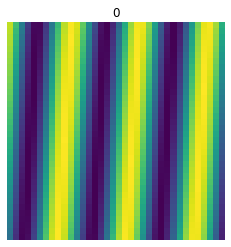

In [101]:
# compute 2D signal and visualize it 
x = (grids.unsqueeze(3) @ freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)).squeeze(3)
x = x + phases.unsqueeze(1).unsqueeze(2)
x = torch.sin(x * (np.pi * 2))

visualize_feature(x.squeeze(), 1, 1)

In [102]:
# As we can see, this signal has relative high freq for x direction, and low freq for y direction. 
# This can also be verified by the above printed freqs 

normalize range is not given, use min and max value in all input tensors


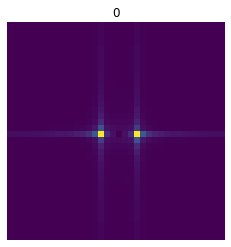

In [103]:
# Now let's compute its FFT. Note that the fft2 in pytorch does not move low frequency into the center 
# as done in almost all visualization, thus the second line is simply moving values around  
fft_map = abs( torch.fft.fft2( x.squeeze() ) )
fft_map = fft_map.roll(shifts=[fft_map.shape[0] // 2, fft_map.shape[1] // 2], dims=[0,1]) 
visualize_feature(fft_map)

In [104]:
# As it can be seen, we have two light dots almost parallel to the x axis. 

normalize range is not given, use min and max value in all input tensors


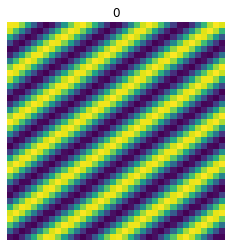

In [105]:
# Now let's increase y axis freq from 0.1 to 2.3, and see signal map 
freqs2 = freqs.clone()
freqs2[0,0,1] = 2.3 # hardcoded

x2 = (grids.unsqueeze(3) @ freqs2.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)).squeeze(3)
x2 = x2 + phases.unsqueeze(1).unsqueeze(2)
x2 = torch.sin(x2 * (np.pi * 2))

visualize_feature(x2.squeeze(), 1, 1)

normalize range is not given, use min and max value in all input tensors


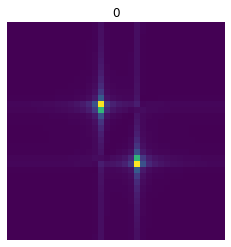

In [106]:
# Let's see its FFT and this time we can clearly see it has y component  
fft_map2 = abs( torch.fft.fft2( x2.squeeze() ) )
fft_map2 = fft_map2.roll(shifts=[fft_map2.shape[0] // 2, fft_map2.shape[1] // 2], dims=[0,1]) 
visualize_feature(fft_map2)

normalize range is not given, use min and max value in all input tensors
normalize range is not given, use min and max value in all input tensors


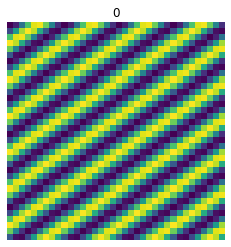

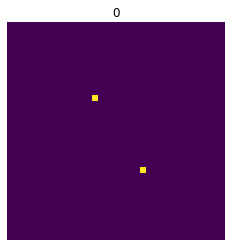

In [118]:
# Now let's set freqs to [2,3]. Then conceptually, x axis f=4 and y axis f=6 (grids is ranging from -1 to 1). 
# Then we can pre-calculate that two points in the feature map will be [ 36/2-6, 36/2-4 ] = [12,14] and 
# [ 36/2+6, 36/2+4 ] = [24,22]

freqs3 = freqs.clone()
freqs3[0,0,0] = 2 # hardcoded
freqs3[0,0,1] = 3 # hardcoded

x3 = (grids.unsqueeze(3) @ freqs3.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)).squeeze(3)
x3 = x3 + phases.unsqueeze(1).unsqueeze(2)
x3 = torch.sin(x3 * (np.pi * 2))
visualize_feature(x3.squeeze())

fft_map3 = abs( torch.fft.fft2( x3.squeeze() ) )
fft_map3 = fft_map3.roll(shifts=[fft_map3.shape[0] // 2, fft_map3.shape[1] // 2], dims=[0,1]) 
visualize_feature(fft_map3)


In [119]:
# we can verify that by printing:
points = (fft_map3 > 0.01).nonzero()
print('Two points location is: ', points[0], points[1])

Two points location is:  tensor([12, 14]) tensor([24, 22])


normalize range is not given, use min and max value in all input tensors
normalize range is not given, use min and max value in all input tensors


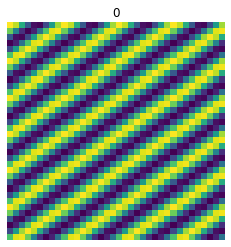

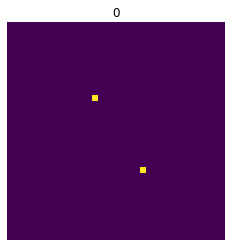

In [120]:
# So far, we haven't set phase, now let's add phase and we hardcoded it as 0.5
phases3_1 = phases.clone()
phases3_1[0,0] = 0.1


freqs3 = freqs.clone()
freqs3[0,0,0] = 2 # hardcoded
freqs3[0,0,1] = 3 # hardcoded

x3_1 = (grids.unsqueeze(3) @ freqs3.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)).squeeze(3)
x3_1 = x3_1 + phases3_1.unsqueeze(1).unsqueeze(2)
x3_1 = torch.sin(x3_1 * (np.pi * 2))
visualize_feature(x3_1.squeeze())

fft_map3_1 = abs( torch.fft.fft2( x3_1.squeeze() ) )
fft_map3_1 = fft_map3_1.roll(shifts=[fft_map3_1.shape[0] // 2, fft_map3_1.shape[1] // 2], dims=[0,1]) 
visualize_feature(fft_map3_1)

In [ ]:
# We can see that, although the feature map is differnet (adding phase means shift), but fft map is still the same.
# Note that both the x and y shift direction are controled by the singal value phase. Since the actual sigal is
# sin(ax+by), a and b are freqs, x and y are coordinates. We we add a phase c. Then it becomes to sin(ax+by+c), where
# c can be decomposed into am+bn, thus the singal is sin( a(x+m)+b(y+n) )